### 3_3 Hough 변환을 사용해 직선과 원 검출

*  lines = cv2HoughLineP(img, rho, theta, threshold[, lines, minLineLength, maxLineGap])
: 검출한 선의 결과 값이 선의 시작과 끝 좌표이다.
    * img : 입력영상, 이미지
    * rho : 거리측정 해상도, 0~1
    * theta : 각도 측정 해상도, 라디안 단위( np.pi/0~180)
    * threshold : 직선으로 판단할 최소한의 동일 개수 
        * 작은 값 : 정확도 감소, 검출 개수 증가
        * 큰 값 : 정확도 증가, 검출 개수 감소 
    * lines : 거물된 선 좌표, N X 1 X 4 배열 ( x1, y1, x2, y2 ) 
    * minLineLength : 선으로 인정할 최소 길이 
    * maxLineGap : 선으로 판단한 최대 간격 
    * min_theta, max_theta : 검출을 위해 사용할 최대, 최소 각도
   

* circles = cv2.Houghcircles(img, method, dp, minDist[, circles, param1, param2, minRadius, maxRadius])
    * img : 입력 영상, 이미지
    * method : 검출 방식 선택, 
        * cv2.HOUGH_GRADIENT 만 가능 
    * dp : 입력 영상, 이미지와 경사 누적의 해상도 반비례율, 1: 입력과 동일, 값이 커질수록 부정확
    * minDist : 원들 중심간의 최소 거리, 0: 에러 (동심원 검출 불가)
    * circles : 검출 원 결과, N X 1 X 3 부동 소수점 배열 (x, y, 반지름)
    * param1 : 캐니 엣지에 전달할 스레시홀드 최대 값(최소 값은 최대 값의 2배 작은 값을 전달)
    * param2 : 경사도 누적 경계 값(값이 작을수록 잘못된 원 검출)
    * minRadius, maxRadius : 원의 최소 반지름, 최대 반지름 (0이면 영상의 크기)

Detected line: (99 401) (372 353)
Detected circle: center=(200.5 200.5), radius=52.29999923706055


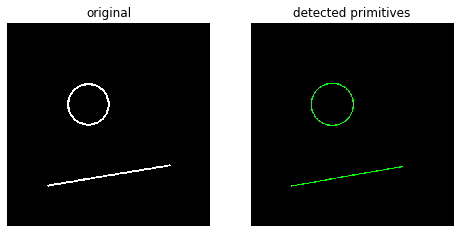

In [3]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

#이미지 그리기
img = np.zeros((500,500), np.uint8)
cv2.circle(img, (200, 200), 50, 255, 3)
cv2.line(img, (100, 400), (400, 350), 255, 3)

#선, 원검출
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15, param1=200, param2=30)[0]
lines = cv2.HoughLinesP(img, 1, np.pi/180, 100, 100, 10)[0]



#검출된 직선과 원을 그린다.
dbg_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)    
for x1, y1, x2, y2 in lines:
    print('Detected line: ({} {}) ({} {})'.format(x1, y1, x2, y2))
    cv2.line(dbg_img, (x1, y1), (x2, y2), (0, 255, 0), 2)    

for c in circles:
    print('Detected circle: center=({} {}), radius={}'.format(c[0], c[1], c[2]))
    cv2.circle(dbg_img, (c[0], c[1]), c[2], (0, 255, 0), 2)
    
#시각화한다. 
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.title('original')
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.title('detected primitives')
plt.axis('off')
plt.imshow(dbg_img)
plt.show()

### 3_3_2 스토쿠이미지 선 검출 

In [ ]:
import cv2
import numpy as np

img = cv2.imread('../img/sudoku.jpg')
img2 = img.copy()
# 그레이 스케일로 변환 및 엣지 검출 ---①
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(imgray, 50, 200 )

# 확율 허프 변환 적용 ---②
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 10, None, 20, 2)
for line in lines:
    # 검출된 선 그리기 ---③
    x1, y1, x2, y2 = line[0]
    cv2.line(img2, (x1,y1), (x2, y2), (0,255,0), 1)

merged = np.hstack((img, img2))
cv2.imshow('Probability hough line', merged)
cv2.waitKey()
cv2.destroyAllWindows()

### 3_5 메디안 플로우 객체 추적기

#### 추적할 객체를 선택

* ret = cv2.selectROI([win_name,] img[, showCrossHair=True, fromCenter=False])
    * win_name : ROI 선택을 진행할 창의 이름, str
    * img : ROI 선택을 진행할 이미지, Numpy ndarray
    * showCrossHair : 선택 영역 중심에 십자 모양 표시 여부 
    * fromCenter : 마우스 시작 지점을 영역의 중심으로 지정 
    * ret : 선택한 영역 좌표와 크기(x, y, w, h)

In [5]:
import cv2
import numpy as np

#비디오 한프레임씩 읽기

cap = cv2.VideoCapture("../data/traffic.mp4")

_, frame = cap.read()

bbox = cv2.selectROI(frame, False, False)

cv2.destroyAllWindows()

#추적할 객체 선택


#### 선택한 객체 추적

cv2.Tracker는 init() 함수로 트랙커에 초기 추적 대상 객체의 위치를 알려주고 
update() 함수에 다음 프레임을 전달하면 객체가 이동한 위치를 반환합니다. 
* tracker = cv2.TrackerMedianFlow_create() : 객체의 전방향/역방향을 추적해서 불일치성 측정

In [6]:
# 메디안 플로우 추적기 생성

#추적기 초기화
tracker = cv2.TrackerMedianFlow_create()
status_tracker = tracker.init(frame, bbox)
fps = 0

while True:
    status_cap, frame = cap.read()
    if not status_cap:
        break

    if status_tracker:
        timer = cv2.getTickCount()
        status_tracker, bbox = tracker.update(frame)
        
    if status_tracker:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 15)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
        cv2.putText(frame, "FPS: %.0f" % fps, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 0, 0), 8);
    else:
        cv2.putText(frame, "Tracking failure detected", (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0,0,255), 8)
        
    cv2.imshow("MedianFlow tracker", frame)

    k = cv2.waitKey(1)
    
    if k == 27: 
        break
    
cv2.destroyAllWindows()

### 3_6 추적 API의 다양한 알고리즘을 사용해 객체 추적

* KCF : Kernelized Correlation Filters 
* MIL : Multiple Instance Learning
* TLD : Tracking, Learning and Detection

In [7]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib auto

cv2.namedWindow('frame')


for name, tracker in (('KCF', cv2.TrackerKCF_create), 
                      ('MIL', cv2.TrackerMIL_create), 
                      ('TLD', cv2.TrackerTLD_create)):
    tracker = tracker()
    initialized = False

    video = cv2.VideoCapture('../data/traffic.mp4')
    bbox = (878, 266, 1153-878, 475-266)

    i = 0
    while True:
        i += 1
        t0 = time.time()
        ok, frame = video.read()
        if not ok: 
            break

        if initialized:
            tracked, bbox = tracker.update(frame)
        else:
            cv2.imwrite('/tmp/frame.png', frame)
            tracked = tracker.init(frame, bbox)
            initialized = True

        fps = 1 / (time.time() - t0)
        cv2.putText(frame, 'tracker: {}, fps: {:.1f}'.format(name, fps),
                    (20, 70), cv2.FONT_HERSHEY_SIMPLEX,  3, (255, 0, 0), 4)            
        if tracked:
            bbox = tuple(map(int, bbox))
            cv2.rectangle(frame, (bbox[0], bbox[1]), 
                          (bbox[0]+bbox[2], bbox[1]+bbox[3]), 
                          (0, 255, 0), 3)
        cv2.imshow('frame', frame)
        if i == 50:
            cv2.imwrite('frame{}.png'.format(name), frame)
        if cv2.waitKey(3) == 27:
            break

cv2.destroyAllWindows()

Using matplotlib backend: Qt5Agg


### P167 체스판과 원 그리드 패턴 검출

 * found, corners = cv2.findChessboardCorners(img, (rows, columns))
    - found : 검출 여부 
    - corners : 검출 좌표

In [18]:
import cv2
import matplotlib.pyplot as plt

In [19]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [9]:
image_chess = cv2.imread('../data/chessboard.png')

found, corners = cv2.findChessboardCorners(image_chess, (6, 9))
assert found == True, "can't find chessboard pattern"

dbg_image_chess = image_chess.copy()
cv2.drawChessboardCorners(dbg_image_chess, (6, 9), corners, found);

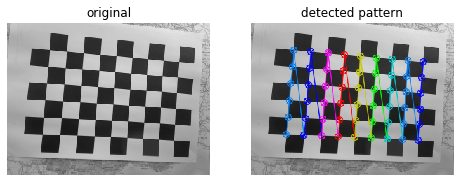

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('original')
plt.axis('off')
plt.imshow(image_chess)
plt.subplot(122)
plt.title('detected pattern')
plt.axis('off')
plt.imshow(dbg_image_chess)
plt.show()

* retval, centers = findCirclesGrid(image, patternSize, flags)
    - flags : 
        - CALIB_CB_SYMMETRIC_GRID* : 대칭 원 패턴에서 사용
        - CALIB_CB_ASYMMETRIC_GRID** 비대칭 원 패턴에서 사용
        - CALIB_CB_CLUSTERING : 알고리즘을 사용하여 강하나, 배경의 노이즈 영향이 크다.

In [31]:
image_circles = cv2.imread('data/circlesgrid.png')






In [32]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('original')
plt.axis('off')
plt.imshow(image_chess)
plt.subplot(222)
plt.title('detected pattern')
plt.axis('off')
plt.imshow(dbg_image_chess)
plt.show()
plt.subplot(223)
plt.title('original')
plt.axis('off')
plt.imshow(image_circles)
plt.subplot(224)
plt.title('detected pattern')
plt.axis('off')
plt.imshow(dbg_image_circles)
plt.tight_layout()
plt.show()

(1) HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins, win_sigma, threshold_L2hys, gamma_correction, nlevels)
- win_size : 탐지 윈도우 사이즈
- block_size : 픽셀에서의 블록 사이즈 , 현재 (16,16) 만 지원됨
- block_stride : 블록의 보폭, 셀 크기의 배수여야 함  
- cell_size : 셀 사이즈, 현재 (8, 8)만 지원됨
- nbins : bin의 갯수, 현재 9 bin 만 지원됨 
- win_sigma : 가우시안 스무딩 윈도우 파라미터, DEFAULT_WIN_SIGMA
- threshold_L2hys :  L2-Hys normalization method shrinkage. 
- gamma_correction : 감마 보정 전처리가 필요한지, True, false
- nlevels : 탐지 창이 최대로 증가함 


(2) setSVMDetector(detector)
- detector : 선형 SVM 분류기 

(3) detectMultiScale(img, found_locations, hit_threshold, win_stride, padding, scale0, group_threshold) 

- img : 원본 이미지, CV_8UC1 and CV_8UC4 타입 만 지원
- found_locations : 탐지된 객체 경계
- hit_threshold : feature와 SVM 평면 간 사이에 대한 임계값, 보통 0, 자유계수, 생략됨 
- win_stride : 윈도우의 폭, 블록 폭의 배수여야 함, 이를 작게 할 수록 탐지 시간이 늘어나며, 반대로 크게 하면 탐색 윈도우 숫자는 더 작아지고, 이는 탐지속도를 빠르게 해주지만 탐지를 못할 확률이 높아짐 
- padding : CPU 인터페이스 호환성을 유지하기 위한 파라미터, (0, 0)이어야 함
- scale0 : 작게 할수록 이미지 레이어의 계수를 증가시키고 계산 시간 증가(피라미드 형식)
- group_threshold : 비슷한 임계 값을 조절하는 계수, 감지 되면 일부 객체는 많은 사각형으로 덮일 수 있음, 0은 그룹화를 수행하지 않음

(4) getDefaultPeopleDetector()
- 함수는 64×128 크기의 윈도우에서 똑바로 서 있는 사람을 검출하는 용도로 훈련된 분류기 계수를 반환
- HOGDescriptor 클래스를 이용하여 원하는 객체를 검출하려면 먼저 검출할 객체에 대해 훈련된 SVM 분류기 계수를 HOGDescriptor::setSVMDetector() 함수에 등록해야 합니다. 


### SVM 모델을 사용한 단순 보행자 검출기
#### 사람의 특징을 가진 객체와 아닌 객체를 구분한다.

In [11]:
import cv2
import matplotlib.pyplot as plt

%matplotlib auto

image = cv2.imread('data/people.jpg')

#검출기와 분류기 정의





plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('original')
plt.axis('off')
plt.imshow(image[:,:,[2,1,0]])
plt.subplot(122)
plt.title('detections')
plt.axis('off')
plt.imshow(dbg_image[:,:,[2,1,0]])
plt.tight_layout()
plt.show()
                  

Using matplotlib backend: Qt5Agg
